In [44]:
import pandas as pd
from sklearn import model_selection
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text # Should not be removed as it is used in side-effect.
from official.nlp import optimization
import matplotlib.pyplot as plt


In [45]:
PREPROCESSED_DATA_PATH = 'assets/preprocessed.csv'
df = pd.read_csv(PREPROCESSED_DATA_PATH, encoding='ISO-8859-1')
data = df['text']
data.fillna('', inplace=True)
labels = df['label'].to_numpy()

In [46]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    data, labels, test_size=0.2, random_state=42)

y_train = tf.keras.utils.to_categorical(LabelEncoder().fit_transform(y_train))
y_test = tf.keras.utils.to_categorical(LabelEncoder().fit_transform(y_test))

In [47]:
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'


def bert_text_classification():

    # Text Input
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')

    # Preprocessing Layer
    preprocessing_layer = hub.KerasLayer(
        tfhub_handle_preprocess, name='preprocessing')

    # Encoding Layer
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder,
                             trainable=True, name='BERT_encoder')

    outputs = encoder(encoder_inputs)

    # Classification Layer
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.2)(net)
    net = tf.keras.layers.Dense(
        y_train.shape[1], activation='softmax', name='classifier')(net)

    model = tf.keras.Model(text_input, net)
    return model


model = bert_text_classification()


In [48]:
loss = tf.keras.losses.CategoricalCrossentropy()

BATCH_SIZE = 128
EPOCHS = 16
LEARNING_RATE = 1e-05

# Use the same optimizer that BERT was originally trained with: the "Adaptive
# Moments" (Adam).
steps_per_epoch = int(len(X_train) / BATCH_SIZE)
num_train_steps = steps_per_epoch * EPOCHS
num_warmup_steps = int(0.1 * num_train_steps / BATCH_SIZE)

optimizer = optimization.create_optimizer(init_lr=LEARNING_RATE,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

# -- compile the model --
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=['accuracy'])


In [49]:
history = model.fit(x=X_train,
                    y=y_train,
                    validation_split=0.2,
                    epochs=EPOCHS,
                    verbose=1,
                    batch_size=BATCH_SIZE)

Epoch 1/16
225/225 [==============================] - 1238s 5s/step - loss: 0.8958 - accuracy: 0.5811 - val_loss: 0.6875 - val_accuracy: 0.7121
Epoch 2/16
225/225 [==============================] - 1233s 5s/step - loss: 0.6798 - accuracy: 0.7222 - val_loss: 0.5949 - val_accuracy: 0.7646
Epoch 3/16
225/225 [==============================] - 1233s 5s/step - loss: 0.5991 - accuracy: 0.7650 - val_loss: 0.5558 - val_accuracy: 0.7869
Epoch 4/16
225/225 [==============================] - 1234s 5s/step - loss: 0.5406 - accuracy: 0.7930 - val_loss: 0.5254 - val_accuracy: 0.8034
Epoch 5/16
225/225 [==============================] - 1238s 6s/step - loss: 0.5012 - accuracy: 0.8145 - val_loss: 0.5103 - val_accuracy: 0.8102
Epoch 6/16
225/225 [==============================] - 1238s 6s/step - loss: 0.4733 - accuracy: 0.8266 - val_loss: 0.4898 - val_accuracy: 0.8223
Epoch 7/16
225/225 [==============================] - 1237s 5s/step - loss: 0.4476 - accuracy: 0.8405 - val_loss: 0.4836 - val_accuracy:

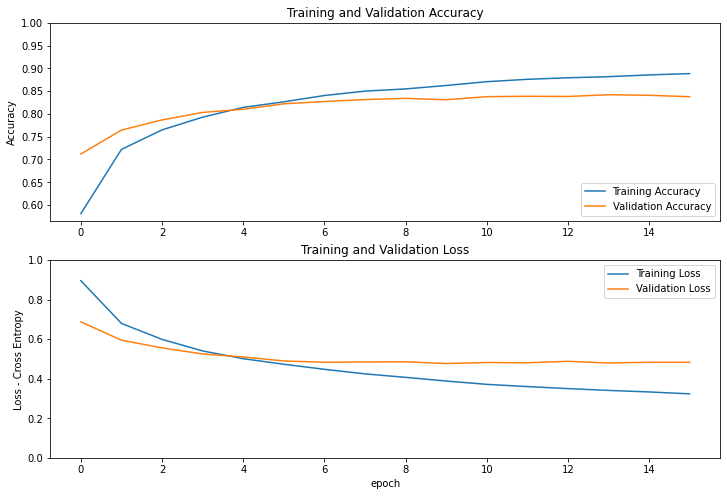

In [50]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss - Cross Entropy')
plt.xlabel('epoch')
plt.ylim([0, 1.0])
plt.title('Training and Validation Loss')

plt.show()


In [51]:
loss, acc = model.evaluate(x=X_test,
                           y=y_test)
print("test loss: ", loss, ", test acc: ", 100 * acc, "%")


281/281 [==============================] - 96s 342ms/step - loss: 0.4685 - accuracy: 0.8397
test loss:  0.4685269594192505 , test acc:  83.9728593826294 %


In [52]:
model.save('bert_classifier_model')


2021-11-28 18:59:59.721933: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: bert_classifier_model/assets


INFO:tensorflow:Assets written to: bert_classifier_model/assets
